# Predicting Online News Popularity
### Xiao Chu, Zhentao Hou, Jingwen Yu
<br></br>

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from calendar import day_name
from rfpimp import *

from sklearn.linear_model import LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, accuracy_score, precision_score,\
                            recall_score, f1_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', 62)

# Load Data

In [2]:
# load data
news = pd.read_csv("OnlineNewsPopularity.csv")

# delete the white space before each column name
news.columns = [col.strip(" ") for col in news.columns]
news.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


# Exploratory Data Analysis

## TODO: insert target exploration

## Feature Exploration

First, we checked the feature correlation heatmap and most of the features are uncorrelated.

In [ ]:
# plot the feature correlation heatmap
corr = plot_corr_heatmap(news, figsize=(20, 20), label_fontsize=9, value_fontsize=7)  # from rfpimp package
corr.view()

Then, we explored the relationship between the target (number of shares) and some selected features:
1. number of words in the content vs number of shares
2. text sentiment polarity vs number of shares

In [ ]:
# number of words in the content vs number of shares
plt.scatter(news["n_tokens_content"], news["shares"])
plt.title("Content Lengths vs Number of Shares", size=15)
plt.xlabel("Number of Words", size=12)
plt.ylabel("Number of Shares", size=12)
plt.show()

In [ ]:
# text sentiment polarity vs number of shares
plt.scatter(news["global_sentiment_polarity"], news["shares"])
plt.title("Text Sentiment Polarity vs Number of Shares", size=15)
plt.xlabel("Polarity Score", size=12)
plt.ylabel("Number of Shares", size=12)
plt.show()

# Plots

In [ ]:
# by day of the week
news_dow = news.iloc[:, 31:39]
news_dow = pd.DataFrame(np.argmax(np.array(news_dow), axis=1))
news_dow["day_name"] = news_dow.applymap(lambda x: day_name[x])
news_dow = pd.concat([news_dow, news_binary_median[["shares", "popularity"]]], axis=1)
news_dow.columns = ["dow", "dow_name", "counts", "popularity"]
news_dow["popularity"] = news_dow["popularity"].apply(lambda x: "popular" if x else "unpopular")
popularity_dow = news_dow.groupby(["dow", "dow_name", "popularity"])["counts"].count().reset_index()
popularity_dow

In [ ]:
# plot news popularity based on day of the week
plt.figure(figsize=(11, 8.5))
sns.barplot(x="dow_name", y="counts", hue="popularity", data=popularity_dow, palette=["C3", "C0"])
plt.title("News Popularity vs Day of the Week\n", size=24)
plt.xlabel("\nDay of the Week", size=15)
plt.xticks(size=15)
plt.ylabel("News Count\n", size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.savefig(fname="Popularity by DOW", dpi=300)
plt.show()

In [ ]:
# by channel
channel_dict = {0: "Lifestyle", 1: "Entertainment", 2: "Business", 3: "Social Media", 4: "Technology", 5: "World",
                6: "Other"}
news_channel = news.iloc[:, 13:19]
news_channel = news_channel.assign(Other=1)
news_channel = pd.DataFrame(np.argmax(np.array(news_channel), axis=1))
news_channel["channel_name"] = news_channel.applymap(lambda x: channel_dict[x])
news_channel = pd.concat([news_channel, news_binary_median[["shares", "popularity"]]], axis=1)
news_channel.columns = ["channel", "channel_name", "counts", "popularity"]
news_channel["popularity"] = news_channel["popularity"].apply(lambda x: "popular" if x else "unpopular")
popularity_channel = news_channel.groupby(["channel", "channel_name", "popularity"])["counts"].count().reset_index()
order = list(popularity_channel[popularity_channel["popularity"] == "popular"]
             .sort_values("counts", ascending=False)["channel_name"])
popularity_channel

In [ ]:
# plot news popularity based on news channel
plt.figure(figsize=(14, 11))
sns.barplot(x="channel_name", y="counts", hue="popularity", order=order, data=popularity_channel, palette=["C3", "C0"])
plt.title("News Popularity vs News Channel\n", size=24)
plt.xlabel("\nNews Channel", size=15)
plt.xticks(size=15)
plt.ylabel("News Count\n", size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.savefig(fname="Popularity by Channel", dpi=300)
plt.show()

In [ ]:
median_threshold = news_binary_median.groupby("popularity")["shares"].count()

In [ ]:
mean_threshold = news_binary_mean.groupby("popularity")["shares"].count()

In [ ]:
popularity_threshold = pd.concat([median_threshold, mean_threshold], axis=0).reset_index()
popularity_threshold["threshold"] = ["median", "median", "mean", "mean"]
popularity_threshold.columns = ["popularity", "counts", "threshold"]
popularity_threshold["popularity"] = (popularity_threshold["popularity"]
                                      .apply(lambda x: "popular" if x else "unpopular"))
popularity_threshold

In [ ]:
# plot news popularity threshold
plt.figure(figsize=(7, 5))
sns.barplot(x="threshold", y="counts", hue="popularity", data=popularity_threshold, palette=["C0", "C3"])
plt.title("Number of Class Instances vs Different Thresholds\n", size=16)
plt.xlabel("Threshold", size=14)
plt.xticks(size=12)
plt.ylabel("Number of Class Instances", size=14)
plt.yticks(size=12)
plt.legend(fontsize=12)
plt.savefig(fname="Threshold", dpi=100)
plt.show()

# Modeling

## Part (a). Regression
Initially, regression models were used to predict the number of shares of a piece of news. All features except for news url and timedelta were included in the model. StandardScaler() was applied to numerical features. Pipelines were created for each regression algorithm.

In [ ]:
# choose features and target
X = news.iloc[:, 2:60]  # all columns except url and target
y = news["shares"].values.ravel()  # target: number of shares

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
# function to create pipelines for different regression algorithms
def regr_pipeline():
    """
    Create a pipeline for each regression algorithm:
    1. Lasso
    2. Ridge
    3. Random Forest Regressor
    
    Use StandardScaler() on numerical features if necessary.
    Return a list of pipelines.
    """
    num_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 37, 38, 39, 40,
                   41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
    num_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_indices)], remainder="passthrough")
    
    lasso = Pipeline(steps=[("preprocessor", preprocessor),
                            ("regressor", LassoCV(cv=5, max_iter=500))])
    ridge = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", RidgeCV(cv=5))])
    rf_regr = Pipeline(steps=[("regressor", RandomForestRegressor(n_estimators=100))])
    pipelines = [lasso, ridge, rf_regr]
    return pipelines

In [ ]:
# fit models with train data
# look at model performance on test data
# evaluation metrics include r^2, mean absolute error and median absolute error
regr_pipelines = regr_pipeline()
regr_eval = []

for pipeline in regr_pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    model_name = pipeline.named_steps['regressor'].__class__.__name__.split('.')[-1]
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    regr_eval.append([model_name, r2, mae, medae])

In [ ]:
# look at evaluation metrics
regr_eval = pd.DataFrame(regr_eval)
regr_eval.columns = ["model", "r2", "mean absolute error", "median absolute error"]
regr_eval

## Part (b). Binary Classification
Using regression models results in large median absolute errors, so we thought classification models may actually make more sense for this problem. All features except for news url and timedelta were included in the model. StandardScaler() was applied to numerical features. Pipelines were created for each classification algorithm.

# TODO: insert distribution with different thresholds

If the mean number of shares (3395) is used as the threshold, the popular and unpopular classes would be imbalanced. Additionally, the large range of number of shares would make the mean not appropriate to divide the news into two classes. Therefore, we decided to choose the median number of shares as the threshold.

### Use the median number of shares as threshold

In [3]:
# add a column with two classes, 0 for unpopular (shares <= 1400) and 1 for popular (shares > 1400)
median = np.median(news["shares"])
news_binary_median = news.assign(popularity=0)
news_binary_median.loc[news_binary_median["shares"] > median, "popularity"] = 1

In [4]:
# choose features and target
X = news_binary_median.iloc[:, 2:60]  # all columns except url, timedelta and target
y = news_binary_median["popularity"].values.ravel()  # target: popularity (two classes, 0 and 1)

# train test split using 80-20 rule
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Build Pipelines

In [5]:
# function to create pipelines for different classification algorithms
def clf_pipeline():
    """
    Create a pipeline for each classification algorithm:
    1. Logistic Regression
    2. K-Nearest Neighbors
    3. Naive Bayes
    4. Random Forest Classifier
    
    Use StandardScaler() on numerical features if necessary.
    Return a list of pipelines.
    """
    num_indices = list(range(11)) + list(range(17, 29)) + list(range(37, 58))  # numerical feature indices
    num_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_indices)], remainder="passthrough")
    
    logistic = Pipeline(steps=[("preprocessor", preprocessor),
                               ("clf", LogisticRegressionCV(cv=5, max_iter=250, solver="lbfgs"))])
    knn = Pipeline(steps=[("preprocessor", preprocessor), ("clf", KNeighborsClassifier())])
    bayes = Pipeline(steps=[("preprocessor", preprocessor), ("clf", GaussianNB())])
    rf_clf = Pipeline(steps=[("clf", RandomForestClassifier(n_estimators=100))])
    pipelines = [logistic, knn, bayes, rf_clf]
    return pipelines

### Fit Models

In [ ]:
# fit models with train data
# look at model performance on test data
# evaluation metrics include accuracy, precision, recall, f1 score, confusion_matrix and classification report
clf_pipelines = clf_pipeline()
clf_eval = []

for pipeline in clf_pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    model_name = pipeline.named_steps['clf'].__class__.__name__.split('.')[-1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    conf_mat = confusion_matrix(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred)
    clf_eval.append([model_name, accuracy, precision, recall, f1, conf_mat, clf_report])

# store evaluation metrics in a dataframe
clf_eval = pd.DataFrame(clf_eval)
clf_eval.columns = ["model", "accuracy", "precision", "recall", "f1 score", "confusion matrix",
                    "classification report"]

### Evaluation Metrics

In [ ]:
# look at model accuracy, precision, recall and F1 score of test data
clf_eval[["model", "accuracy", "precision", "recall", "f1 score"]]

In [ ]:
# look at model confusion matrix of test data
plt.figure(figsize=(11, 8.5))
for idx in range(4):
    plt.subplot(2, 2, idx + 1)
    plt.subplots_adjust(wspace=0.5, hspace=0.4)
    ax = sns.heatmap(clf_eval["confusion matrix"][idx], cmap="Blues", annot=True, annot_kws={"size": 18}, fmt="d")
    ax.set_title(f"{clf_eval['model'][idx]}", size=16)
    ax.xaxis.set_ticklabels(["unpopular", "popular"], size=14)
    ax.yaxis.set_ticklabels(["unpopular", "popular"], size=14, rotation=0)

## Hyperparameter Tuning
\
Grid search and random search were too slow for this dataset. Instead, we used cross validation scores with cv = 5 and manually tuned some hyperparameters of the random forest classifier, including n_estimators, min_samples_leaf and max_features.

In [7]:
# tune n_estimators
for num in range(10, 140, 20):
    rf = RandomForestClassifier(n_estimators=num)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1_weighted")
    print(f"n_estimators: {num}, cross validation scores: {scores}")

n_estimators: 10, cross validation scores: [0.62656942 0.62350799 0.61205663 0.61527021 0.62130108]
n_estimators: 30, cross validation scores: [0.64963143 0.64440237 0.64430475 0.65028152 0.65700471]
n_estimators: 50, cross validation scores: [0.65805061 0.6516759  0.6397617  0.65558227 0.65705439]
n_estimators: 70, cross validation scores: [0.66138772 0.64720973 0.64688532 0.66118354 0.66034694]
n_estimators: 90, cross validation scores: [0.65947998 0.6573187  0.654972   0.66725231 0.66812291]
n_estimators: 110, cross validation scores: [0.67055151 0.66094996 0.65490839 0.67084481 0.66642662]
n_estimators: 130, cross validation scores: [0.66410996 0.65685285 0.65400632 0.66629463 0.66870188]


In [8]:
# choose n_estimators = 110
# tune max_features
for num in range(4, 9, 1):
    rf = RandomForestClassifier(n_estimators=110, max_features=num)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1_weighted")
    print(f"max_features: {num}, cross validation scores: {scores}")

max_features: 4, cross validation scores: [0.66110923 0.65933961 0.65562667 0.66357436 0.66765261]
max_features: 5, cross validation scores: [0.67135996 0.65701913 0.65147048 0.67013249 0.66333716]
max_features: 6, cross validation scores: [0.66882618 0.65258678 0.65159386 0.66463172 0.66658734]
max_features: 7, cross validation scores: [0.66599278 0.64849305 0.64991787 0.66046598 0.66712343]
max_features: 8, cross validation scores: [0.66707609 0.65937483 0.6521839  0.66456739 0.67100549]


In [9]:
# choose n_estimators = 110 and max_features = 5
# tune min_samples_leaf
for num in range(1, 9, 2):
    rf = RandomForestClassifier(n_estimators=110, max_features=5, min_samples_leaf=num)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1_weighted")
    print(f"min_samples_leaf: {num}, cross validation scores: {scores}")

min_samples_leaf: 1, cross validation scores: [0.67212606 0.66076646 0.65279281 0.66562271 0.66887121]
min_samples_leaf: 3, cross validation scores: [0.67151023 0.66458395 0.65217652 0.66581511 0.67043162]
min_samples_leaf: 5, cross validation scores: [0.67009837 0.6593832  0.65419266 0.66833512 0.66598092]
min_samples_leaf: 7, cross validation scores: [0.66883908 0.66456808 0.65283642 0.67056486 0.67017003]


Based on the results of manually tuning, we noticed that tuning max_features and min_samples_leaf gave very similar results when varying the numbers. Considering the combination of F1 score and efficiency, we decided to choose n_estimators = 100, max_features = 5 and min_samples_leaf = 7 for our final model.

## Final Model

In [11]:
# fit final model with train data
final_model = RandomForestClassifier(n_estimators=110, max_features=5, min_samples_leaf=7)
final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
# North Star Metric: F1 Score
# performance on test data
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}, F1 Score: {f1}")

Accuracy: 0.6674233825198638, F1 Score: 0.6660757249588452


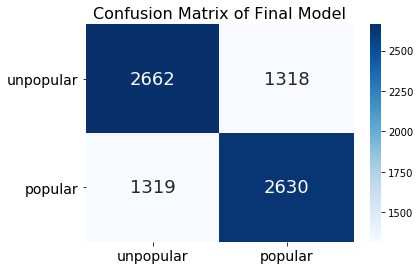

In [19]:
# visualize the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, cmap="Blues", annot=True, annot_kws={"size": 18}, fmt="d")
ax.set_title(f"Confusion Matrix of Final Model", size=16)
ax.xaxis.set_ticklabels(["unpopular", "popular"], size=14)
ax.yaxis.set_ticklabels(["unpopular", "popular"], size=14, rotation=0)
plt.show()

## Feature Importance

In [ ]:
# extract feature importance 
imp = importances(final_model, X_test, pd.DataFrame(y_test))

In [ ]:
# plot top 10 feature importance
imp_top10 = imp[:10].reset_index()
plt.figure(figsize=(8, 6), dpi=100)
sns.barplot(x="Importance", y="Feature", data=imp_top10)
plt.title("Top 10 Important Features", size=20)
plt.xlabel("Importance", size=12)
plt.xticks(size=10)
plt.ylabel("Features", size=12)
plt.yticks(size=10)
plt.savefig(fname="Importance Features", dpi=200)
plt.show()

# Summary
For this project, we initially tried to predict the number of shares of a piece of news with regression models. We fitted three algorithms, **Lasso**, **Ridge** and **Random Forest Regressor**, and found that the median absolute error (MedAE) was around 1600, which is very high considering that some news only has a few hundred shares.\
\
We then treated this problem as classification and used the median number of shares (1400) as a threshold to divide the news into two classes, popular and unpopular. We fitted four algorithms, **Logistic Regression**, **K-Nearest Neighbors**, **Gaussian Naive Bayes** and **Random Forest Classifier**, and found that **Random Forest Classifier** has the best performance using F1 score as North Star Metric.\
\
We manually tuned the hyperparameters of random forest classifier based on cross validation scores since grid/random search is too slow for this dataset. Our final model had a **F1 score of 0.67** and **accuracy of 67%** for the test data.

# Takeaways
- Choose an appropriate analysis method (regression/classification)
- Recommendations for reporters and business entities:\
(1) Keywords are important.\
(2) Publication time matters.\
(3) Referencing articles with high popularity would be helpful.